In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as msle
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
from neuralprophet import NeuralProphet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import optuna
import matplotlib.pyplot as plt
import shap
import warnings
shap.initjs()
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定するよ
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:, 4f}'.format)

### Prophetによる予想

In [40]:
def rmsle(y_true, y_pred):
    
    return np.sqrt(msle(y_true, y_pred))

In [41]:
df = pd.read_csv('train_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)
df_test = pd.read_csv('test_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)

df_scaler = df.copy()
df_test_scaler = df_test.copy()

df_scaler_train, df_scaler_val = train_test_split(df, test_size=0.2, shuffle=False)


def format_date_time(df):

    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

    return df


df_scaler = format_date_time(df_scaler)
df_scaler_train = format_date_time(df_scaler_train)
df_scaler_val = format_date_time(df_scaler_val)
df_test_scaler = format_date_time(df_test_scaler)

In [42]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
target_names = ['CO', 'C6H6', 'NOx']

features = df.columns.to_list()
features.remove('date_time')


for i in targets:

    features.remove(i)

In [43]:
def log_trans(df, features: 'list'):

    for i in features:

        df[i] = np.log1p(df[i])

    return df

df = log_trans(df, targets)

In [95]:
df_test = df_test.rename(columns={'date_time': 'ds'})

In [44]:
df_CO = df.drop([targets[1], targets[2]], axis=1)
df_C6H6 = df.drop([targets[0], targets[2]], axis=1)
df_NOx = df.drop([targets[0], targets[1]], axis=1)

df_CO = df_CO.rename(columns={'date_time': 'ds', targets[0]: 'y'})
df_C6H6 = df_C6H6.rename(columns={'date_time': 'ds', targets[1]: 'y'})
df_NOx = df_NOx.rename(columns={'date_time': 'ds', targets[2]: 'y'})

df_CO_train, df_CO_val = train_test_split(df_CO, test_size=0.2, shuffle=False)
df_C6H6_train, df_C6H6_val = train_test_split(df_C6H6, test_size=0.2, shuffle=False)
df_NOx_train, df_NOx_val = train_test_split(df_NOx, test_size=0.2, shuffle=False)

In [45]:
# Optunaでパラメーター最適化
def objective_variable(train,valid):

    cap = int(np.max(train.y))
    floor = int(np.min(train.y))

    def objective(trial):
            params = {
                    'changepoint_range' : trial.suggest_discrete_uniform('changepoint_range',0.8,0.95,0.001),
                    'n_changepoints' : trial.suggest_int('n_changepoints',20,35),
                    'changepoint_prior_scale' : trial.suggest_discrete_uniform('changepoint_prior_scale',0.001,0.5,0.001),
                    'seasonality_prior_scale' : trial.suggest_discrete_uniform('seasonality_prior_scale',1,25,0.5),
                     }
            # fit_model
            model = Prophet(
                    changepoint_range = params['changepoint_prior_scale'],
                    n_changepoints=params['n_changepoints'],
                    changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')
            
            for i in range(len(features)):
                 model.add_regressor(features[i])

            train['cap'] = cap
            train['floor'] = floor

            model.fit(train)

            valid['cap'] = cap
            valid['floor'] = floor           

            forecast = model.predict(valid)

            val_rmsle = rmsle(np.expm1(valid.y), np.expm1(forecast.yhat).clip(0))
            return val_rmsle

    return objective


def get_parameter(train,valid):
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123), direction='minimize')
    study.optimize(objective_variable(train,valid), timeout=60*60)

    return study

In [46]:
study_CO = get_parameter(df_CO_train, df_CO_val)

13:44:39 - cmdstanpy - INFO - Chain [1] start processing
13:44:42 - cmdstanpy - INFO - Chain [1] done processing
13:44:49 - cmdstanpy - INFO - Chain [1] start processing
13:44:53 - cmdstanpy - INFO - Chain [1] done processing
13:44:59 - cmdstanpy - INFO - Chain [1] start processing
13:45:02 - cmdstanpy - INFO - Chain [1] done processing
13:45:08 - cmdstanpy - INFO - Chain [1] start processing
13:45:11 - cmdstanpy - INFO - Chain [1] done processing
13:45:18 - cmdstanpy - INFO - Chain [1] start processing
13:45:20 - cmdstanpy - INFO - Chain [1] done processing
13:45:27 - cmdstanpy - INFO - Chain [1] start processing
13:45:32 - cmdstanpy - INFO - Chain [1] done processing
13:45:39 - cmdstanpy - INFO - Chain [1] start processing
13:45:41 - cmdstanpy - INFO - Chain [1] done processing
13:45:48 - cmdstanpy - INFO - Chain [1] start processing
13:45:49 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing
13:45:59 - cmdstanpy - INFO - Chain [1]

In [47]:
study_C6H6 = get_parameter(df_C6H6_train, df_C6H6_val)

13:46:45 - cmdstanpy - INFO - Chain [1] start processing
13:46:48 - cmdstanpy - INFO - Chain [1] done processing
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
13:46:59 - cmdstanpy - INFO - Chain [1] done processing
13:47:06 - cmdstanpy - INFO - Chain [1] start processing
13:47:08 - cmdstanpy - INFO - Chain [1] done processing
13:47:15 - cmdstanpy - INFO - Chain [1] start processing
13:47:18 - cmdstanpy - INFO - Chain [1] done processing
13:47:25 - cmdstanpy - INFO - Chain [1] start processing
13:47:28 - cmdstanpy - INFO - Chain [1] done processing
13:47:35 - cmdstanpy - INFO - Chain [1] start processing
13:47:39 - cmdstanpy - INFO - Chain [1] done processing
13:47:46 - cmdstanpy - INFO - Chain [1] start processing
13:47:49 - cmdstanpy - INFO - Chain [1] done processing
13:47:55 - cmdstanpy - INFO - Chain [1] start processing
13:47:57 - cmdstanpy - INFO - Chain [1] done processing
13:48:04 - cmdstanpy - INFO - Chain [1] start processing
13:48:07 - cmdstanpy - INFO - Chain [1]

In [48]:
study_NOx = get_parameter(df_NOx_train, df_NOx_val)

13:48:53 - cmdstanpy - INFO - Chain [1] start processing
13:48:56 - cmdstanpy - INFO - Chain [1] done processing
13:49:02 - cmdstanpy - INFO - Chain [1] start processing
13:49:05 - cmdstanpy - INFO - Chain [1] done processing
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:15 - cmdstanpy - INFO - Chain [1] done processing
13:49:22 - cmdstanpy - INFO - Chain [1] start processing
13:49:24 - cmdstanpy - INFO - Chain [1] done processing
13:49:31 - cmdstanpy - INFO - Chain [1] start processing
13:49:33 - cmdstanpy - INFO - Chain [1] done processing
13:49:40 - cmdstanpy - INFO - Chain [1] start processing
13:49:44 - cmdstanpy - INFO - Chain [1] done processing
13:49:51 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:50:01 - cmdstanpy - INFO - Chain [1] done processing
13:50:07 - cmdstanpy - INFO - Chain [1] start processing
13:50:11 - cmdstanpy - INFO - Chain [1]

In [86]:
model_CO = Prophet(changepoint_range = study_CO.best_params['changepoint_prior_scale'],
                    n_changepoints = study_CO.best_params['n_changepoints'],
                    changepoint_prior_scale = study_CO.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_CO.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_CO.add_regressor(features[i])

df_CO_train['cap'] = int(np.max(df_CO_train.y))
df_CO_train['floor'] = int(np.min(df_CO_train.y))

model_CO.fit(df_CO_train)

df_CO_val['cap'] = int(np.max(df_CO_train.y))
df_CO_val['floor'] = int(np.min(df_CO_train.y))

pred_val_CO = model_CO.predict(df_CO_val)

14:04:42 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
model_C6H6 = Prophet(changepoint_range = study_C6H6.best_params['changepoint_prior_scale'],
                    n_changepoints = study_C6H6.best_params['n_changepoints'],
                    changepoint_prior_scale = study_C6H6.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_C6H6.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_C6H6.add_regressor(features[i])

df_C6H6_train['cap'] = int(np.max(df_C6H6_train.y))
df_C6H6_train['floor'] = int(np.min(df_C6H6_train.y))

model_C6H6.fit(df_C6H6_train)

df_C6H6_val['cap'] = int(np.max(df_C6H6_train.y))
df_C6H6_val['floor'] = int(np.min(df_C6H6_train.y))

pred_val_C6H6 = model_C6H6.predict(df_C6H6_val)

14:04:54 - cmdstanpy - INFO - Chain [1] start processing
14:04:57 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
model_NOx = Prophet(changepoint_range = study_NOx.best_params['changepoint_prior_scale'],
                    n_changepoints = study_NOx.best_params['n_changepoints'],
                    changepoint_prior_scale = study_NOx.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_NOx.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_NOx.add_regressor(features[i])

df_NOx_train['cap'] = int(np.max(df_NOx_train.y))
df_NOx_train['floor'] = int(np.min(df_NOx_train.y))

model_NOx.fit(df_NOx_train)

df_NOx_val['cap'] = int(np.max(df_NOx_train.y))
df_NOx_val['floor'] = int(np.min(df_NOx_train.y))

pred_val_NOx = model_NOx.predict(df_NOx_val)

14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:06 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
pred_val_CO = pred_val_CO.yhat.values
pred_val_C6H6 = pred_val_C6H6.yhat.values
pred_val_NOx = pred_val_NOx.yhat.values

rmsle_CO = rmsle(np.expm1(df_CO_val.y.values), np.expm1(pred_val_CO).clip(0))
rmsle_C6H6 = rmsle(np.expm1(df_C6H6_val.y.values), np.expm1(pred_val_C6H6).clip(0))
rmsle_NOx = rmsle(np.expm1(df_NOx_val.y.values), np.expm1(pred_val_NOx).clip(0))

In [96]:
model_CO_2 = Prophet(changepoint_range = study_CO.best_params['changepoint_prior_scale'],
                    n_changepoints = study_CO.best_params['n_changepoints'],
                    changepoint_prior_scale = study_CO.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_CO.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_CO_2.add_regressor(features[i])


df_CO['cap'] = int(np.max(df_CO.y))
df_CO['floor'] = int(np.min(df_CO.y))

model_CO_2.fit(df_CO)

df_test['cap'] = int(np.max(df_CO.y))
df_test['floor'] = int(np.min(df_CO.y))

pred_CO_log = model_CO_2.predict(df_test)

pred_CO = np.expm1(pred_CO_log.yhat).clip(0)

14:09:25 - cmdstanpy - INFO - Chain [1] start processing
14:09:28 - cmdstanpy - INFO - Chain [1] done processing


In [97]:
model_C6H6_2 = Prophet(changepoint_range = study_C6H6.best_params['changepoint_prior_scale'],
                    n_changepoints = study_C6H6.best_params['n_changepoints'],
                    changepoint_prior_scale = study_C6H6.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_C6H6.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_C6H6_2.add_regressor(features[i])


df_C6H6['cap'] = int(np.max(df_C6H6.y))
df_C6H6['floor'] = int(np.min(df_C6H6.y))

model_C6H6_2.fit(df_C6H6)

df_test['cap'] = int(np.max(df_C6H6.y))
df_test['floor'] = int(np.min(df_C6H6.y))

pred_C6H6_log = model_C6H6_2.predict(df_test)

pred_C6H6 = np.expm1(pred_C6H6_log.yhat).clip(0)

14:09:43 - cmdstanpy - INFO - Chain [1] start processing
14:09:44 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
model_NOx_2 = Prophet(changepoint_range = study_NOx.best_params['changepoint_prior_scale'],
                    n_changepoints = study_NOx.best_params['n_changepoints'],
                    changepoint_prior_scale = study_NOx.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_NOx.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_NOx_2.add_regressor(features[i])


df_NOx['cap'] = int(np.max(df_NOx.y))
df_NOx['floor'] = int(np.min(df_NOx.y))

model_NOx_2.fit(df_NOx)

df_test['cap'] = int(np.max(df_NOx.y))
df_test['floor'] = int(np.min(df_NOx.y))

pred_NOx_log = model_NOx_2.predict(df_test)

pred_NOx = np.expm1(pred_NOx_log.yhat).clip(0)

14:09:58 - cmdstanpy - INFO - Chain [1] start processing
14:10:00 - cmdstanpy - INFO - Chain [1] done processing


##### 結果：

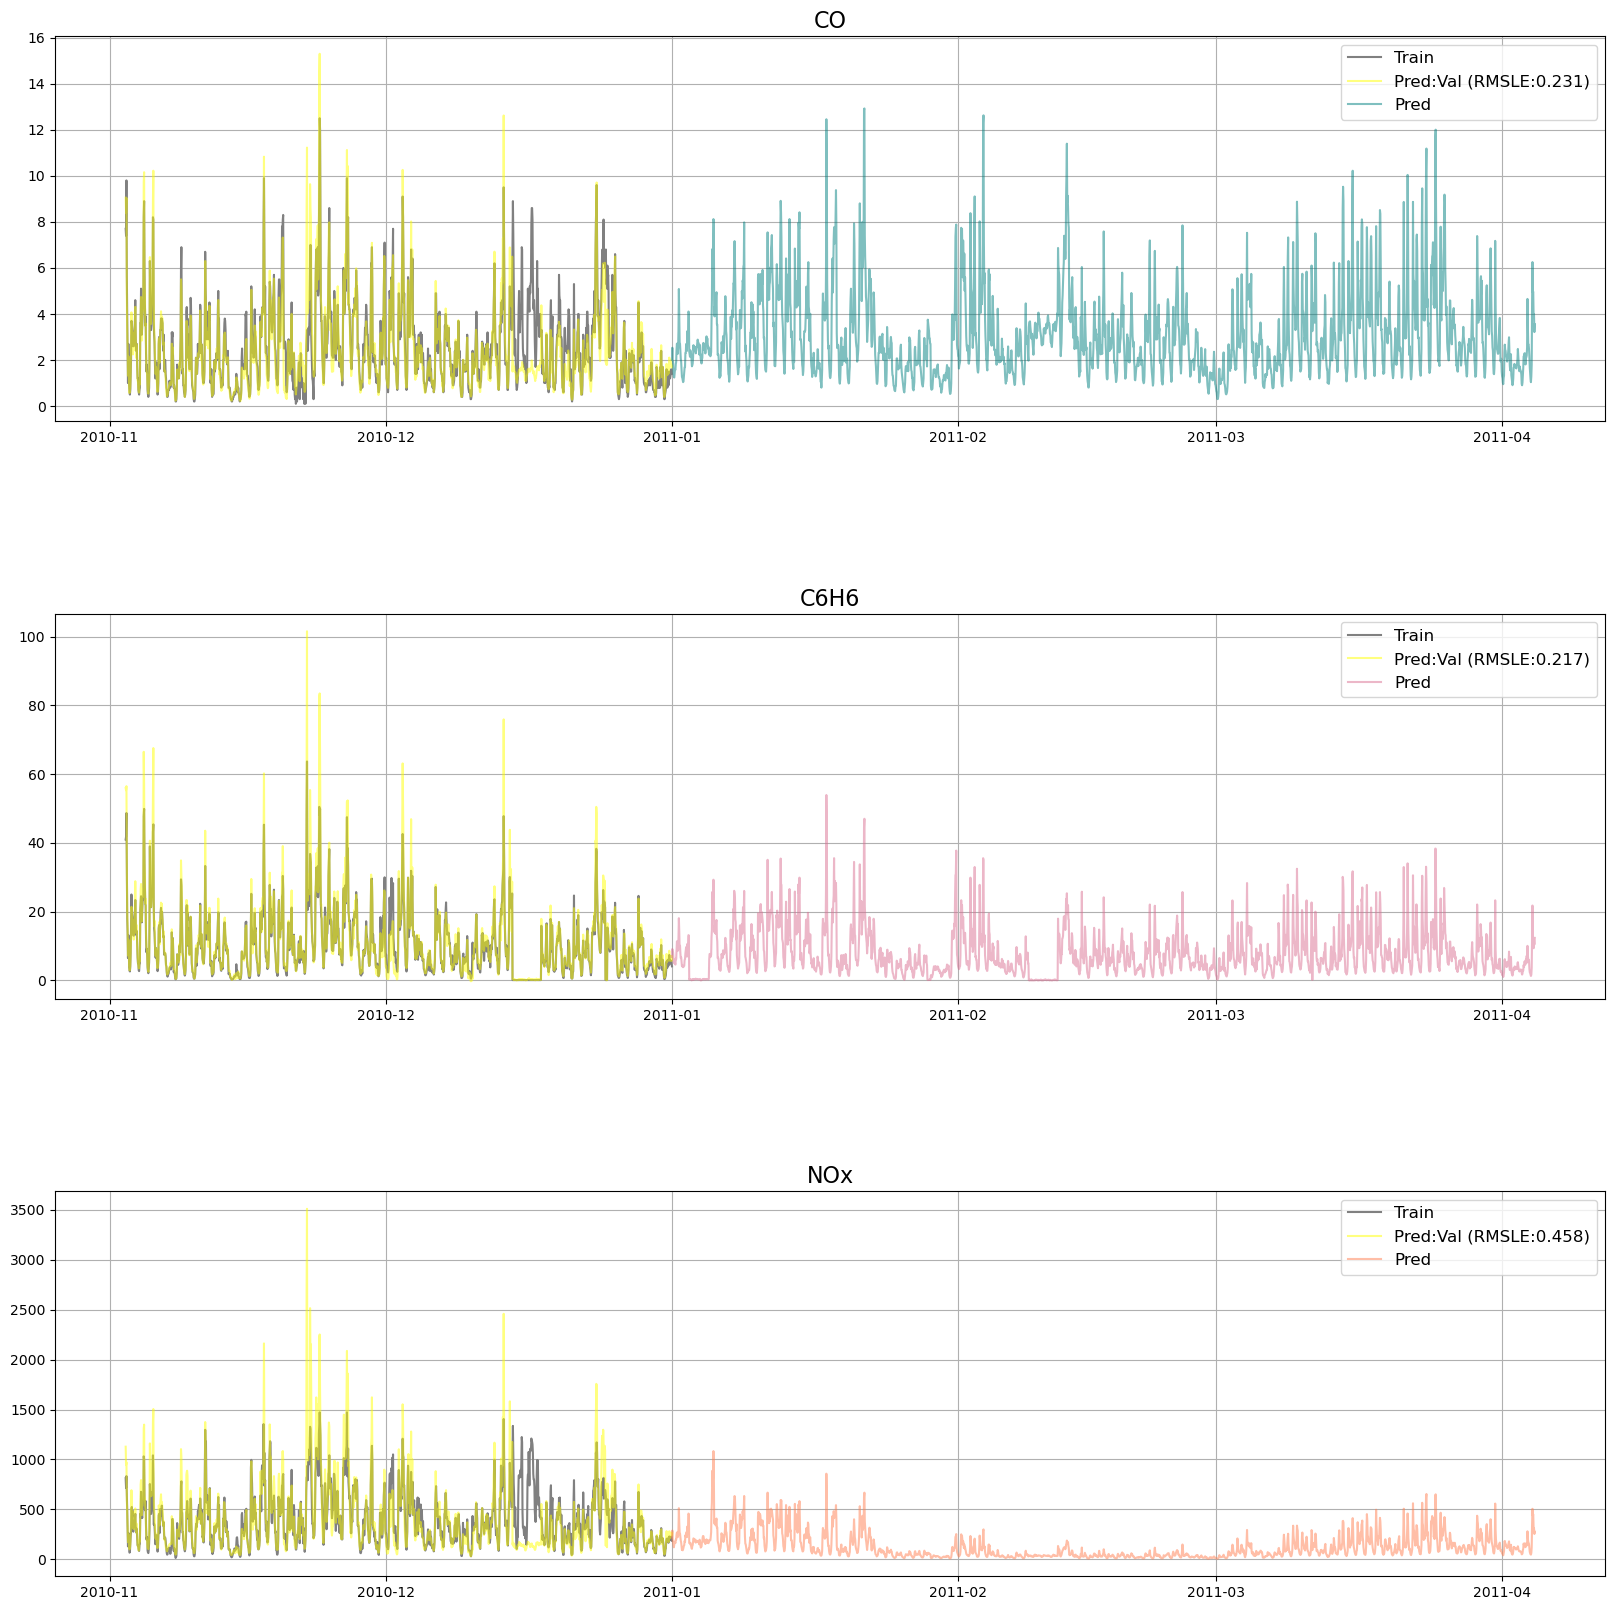

In [109]:
colors = ['teal', 'palevioletred', 'coral']

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'df_{target_names[i]}_val'
    name2 = f'pred_val_{target_names[i]}' 
    name3 = f'rmsle_{target_names[i]}'
    name4 = f'pred_{target_names[i]}'

    axs[i].plot(df_scaler_val['date_time'], np.expm1(globals()[name1].y), color='gray', label='Train')
    axs[i].plot(df_scaler_val['date_time'], np.expm1(globals()[name2]), color='yellow', alpha=0.5, label=f'Pred:Val (RMSLE:{globals()[name3]:.3f})')
    axs[i].plot(df_test_scaler['date_time'], globals()[name4], color=colors[i], alpha=0.5, label='Pred')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')
    axs[i].legend(fontsize=12)

plt.show()

In [107]:
submit_base = pd.read_csv('sample_submission.csv')

submit = pd.DataFrame()

submit['date_time'] = submit_base['date_time']
submit[targets[0]] = pred_CO
submit[targets[1]] = pred_C6H6
submit[targets[2]] = pred_NOx

submit.to_csv('submission_prophet.csv', index=False)